<a href="https://colab.research.google.com/github/lapshinaaa/homework_machineLearning/blob/main/gradient_descent_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 5. Градиентный спуск. (10 баллов + 2.5 бонус)

В этом домашнем задании вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

In [36]:
from typing import Iterable, List

import matplotlib.pyplot as plt
import numpy as np

## Часть 1. Градиентный спуск (5 баллов)

Для начала давайте вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. Менять его не нужно. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения градиента (вектор)

In [37]:
import abc


class BaseLoss(abc.ABC):
    """Базовый класс лосса"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Теперь давайте напишем реализацию этого абстрактоного класса: Mean Squared Error лосс.

**Задание 1.1 (5/8 балла):** Реализуйте класс `MSELoss`

Он должен вычислять лосс и градиент по формулам наверху

In [38]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        calculated_loss = np.square(np.dot(X, w) - y).mean(axis=None) # calculating the loss
        return calculated_loss

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        subtracted_matrices = np.dot(X, w) - y  # calculating the multiplier

        # X.shape[0] is used to divide each element in an array by the number of samples
        calculated_gradient = np.dot(np.transpose(X), subtracted_matrices) / X.shape[0]

        return calculated_gradient * 2

Теперь мы можем создать объект `MSELoss` и при помощи него вычислять значение нашей функции потерь и градиенты:

In [39]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

**Задание 1.2 (5/8 балла):** Реализуйте функцию `gradient_descent`

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`, 
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше и возвращать 
траекторию спуска (список из новых значений весов на каждом шаге)

In [40]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 10000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """

    # including the initial weights in the weights history
    weights = [w_init]

    for iteration in range(n_iterations):
      previous_weights = weights[-1]
      weights_renewed = previous_weights - lr * loss.calc_grad(X, y, previous_weights)
      weights.append(weights_renewed) #appending the new weights to the list
    
    return weights

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [41]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [42]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.58917680450253
0.8670644395649493


In [43]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

**Задание 1.3 (5/8 балла):** При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`. 

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

Подсказки:
* Функция `gradient_descent` возвращает историю весов, которую нужно подать в функцию `plot_gd`
* Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

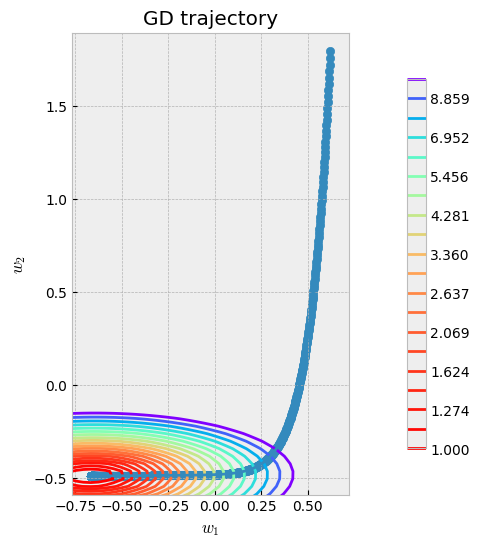

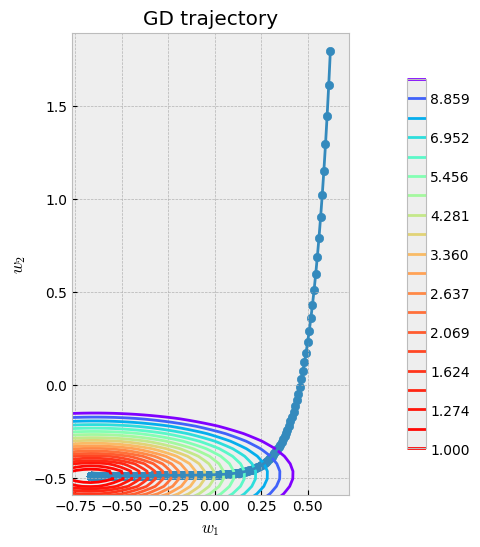

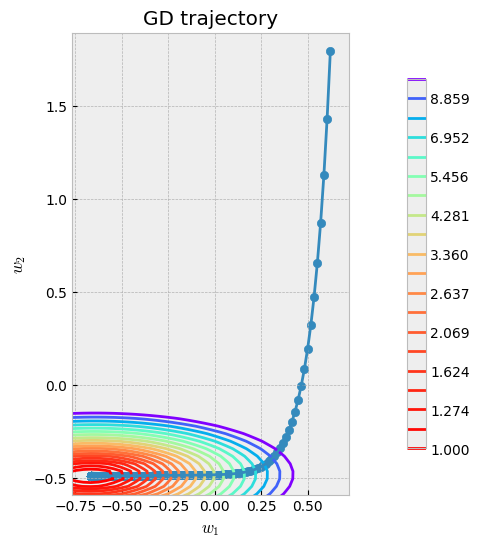

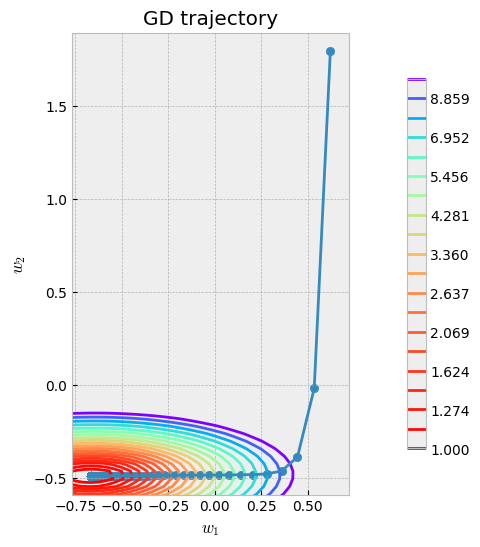

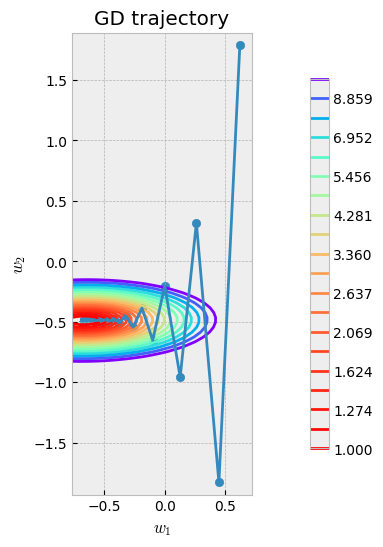

CPU times: user 7.93 s, sys: 578 ms, total: 8.51 s
Wall time: 7.93 s


In [44]:
# measuring time required to run this code for later comparison with SGD
%%time 
# setting the values for learning rate
lr_values = [0.0001, 0.0005, 0.001, 0.005, 0.01]

# plotting the subplots for each learning rate
for learning_rate in lr_values:
  weights_list = gradient_descent(w_init, X, y, loss, learning_rate, 100000)
  plot_gd(weights_list, X, y, loss)


# Попыталась сделать через subplot, но из-за структуры функции 'plot_gd' реализация такой идеи не представляется возможной,
# поскольку каждый из сабплотов рисуется как отдельный график. 

# Выводы о влиянии параметра lr на поведение градиентного спуска:
# Маленькое значение шага приводит к тому, что градиентный спуск двигается очень медленно, и напротив,
# слишком большое значение данного параметра приводит к тому, что оптимальный (хороший) локальный минимум (если мы рассматриваем
# случай с несколькими локальными минимумами, среди которых есть наиболее оптимальные) может быть перепрыгнут.
# В частном случае, если минимум у функции только один, то, чем меньше значение шага, тем медленнее движется GD.
# При большом значении lr алгоритм может не сойтись к минимуму и начать расходиться. 

Теперь реализуем стохастический градиентный спуск

**Задание 1.4 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent`

Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча. 

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [45]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 10000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
  #  w = w_init
    w_hist = []
    w_hist.append(w_init)
    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        grad = loss.calc_grad(X_batch, y_batch, w_hist[-1])
        
        w = w_hist[-1] - lr * grad
        w_hist.append(w)
    return w_hist

**Задание 1.5 (5/8 балла):** При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`. 

Сделайте и опишите свои выводы о том, как параметры  `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

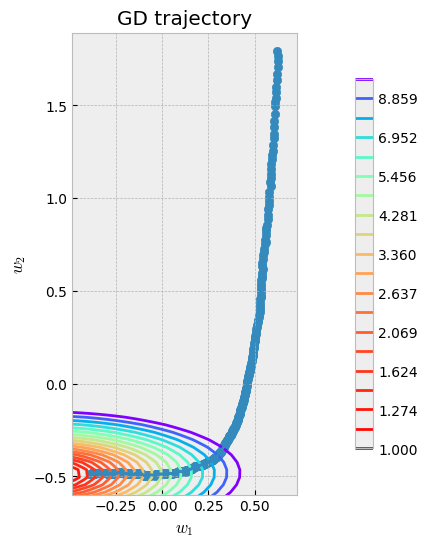

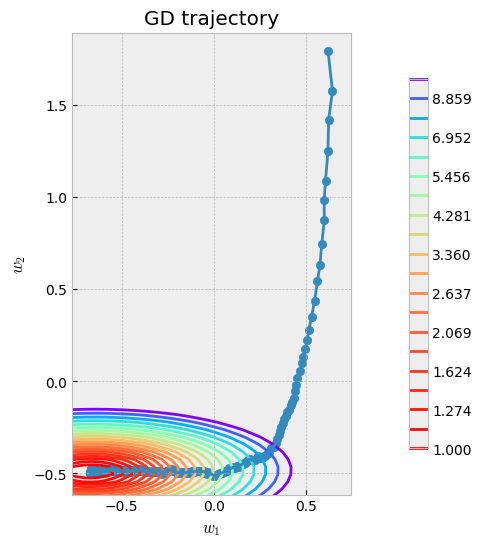

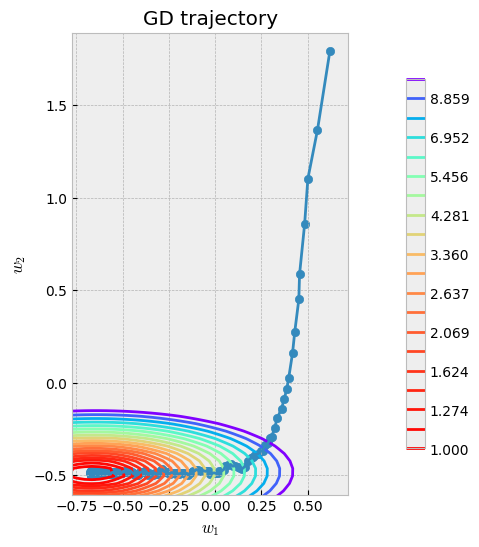

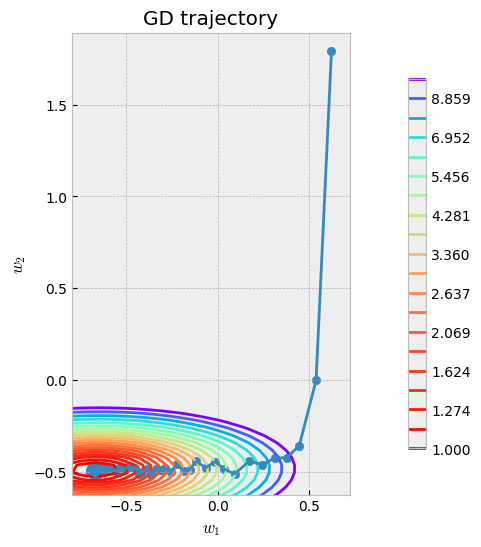

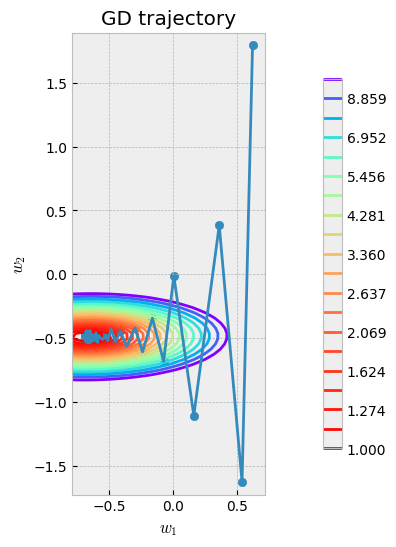

CPU times: user 2.44 s, sys: 500 ms, total: 2.94 s
Wall time: 2.49 s


In [46]:
%%time
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
batch_sizes = [16, 20, 32, 64, 100]

# I will have a look at 5 different trajectories (not all combinations of lr and batch sizes):
for i in range(len(learning_rates)):
  stochastic_weights = stochastic_gradient_descent(w_init, X, y, loss, learning_rates[i], batch_sizes[i], 1000)
  plot_gd(stochastic_weights, X, y, loss)

# Выводы: в первую очередь, следует отметить, что за счёт сокращения размера выборки, SGD оказывается значительно 
# быстрее GD (для этого я использовала %%time). Траектория SGD, как правило, более 'noisy' и хаотичная по сравнению
# с классическим GD. При этом, чем больше размера батча, тем более точным оказывается результат работы модели.
# При этом, логично отметить, что больший размер выборки приводит к замедлению вычисления оптимальных весов.
# Влияние параметра 'learning rate' на поведение траектории уже было описано мною ранее, но я еще раз отмечу, что
# очень маленький шаг (0,0001) приводит к тому, что веса обновляются незначительно. В общем случае это может привести к
# тому, что модель застрянет в локальном минимуме и не сможет сдвинуться, чтобы найти более оптимальные веса. 
# С увеличением значения lr, траектория также становится более "chaotic" и "noisy".

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага. 

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его. 

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

**Задание 1.6 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [47]:
from numpy.lib.arraypad import pad
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 10000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    # including the initial weights in the weights history
    weights = [w_init]

    for iteration in range(n_iterations):
      # randomly selecting a batch of the size 'batch_size':
      batch_indices = np.random.choice(X.shape[0], size = batch_size, replace = False)
      batch = X[batch_indices]

      # calculating new learning rate:
      learning_rate = lr * ((1 / (1 + iteration)) ** p) # the value of 'learning rate' should equal 'lr' (initial) in the first iteration

      #calculating new weights:
      previous_weights = weights[-1]
      current_weights = previous_weights - learning_rate * loss.calc_grad(batch, y[batch_indices], previous_weights)
      weights.append(current_weights)

    return weights

**Задание 1.7 (5/8 балла):** При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

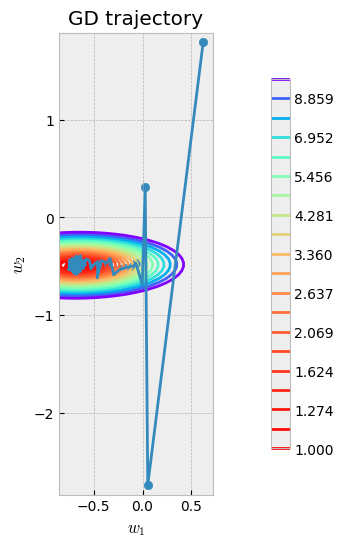

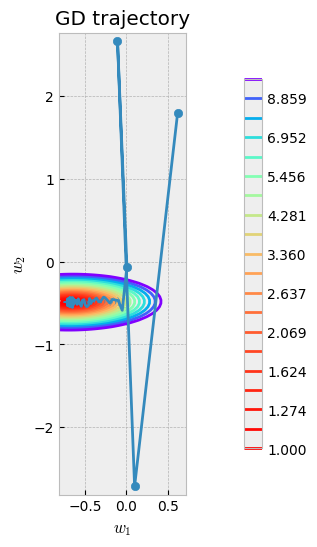

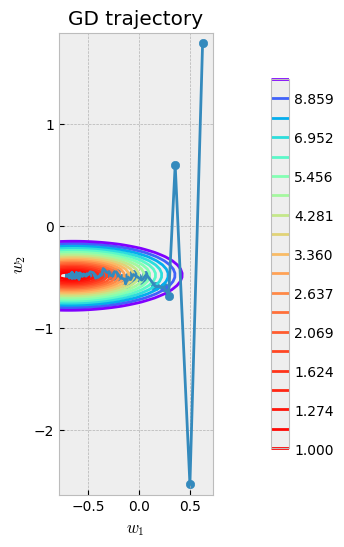

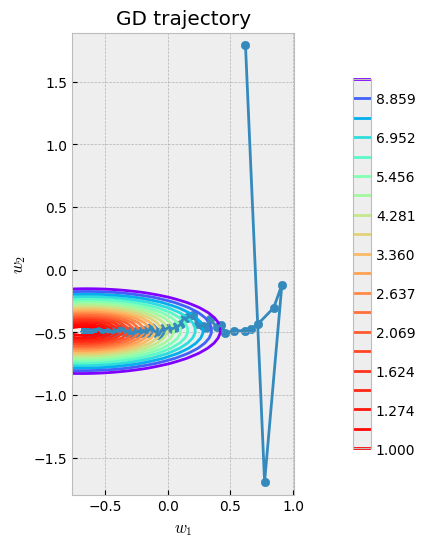

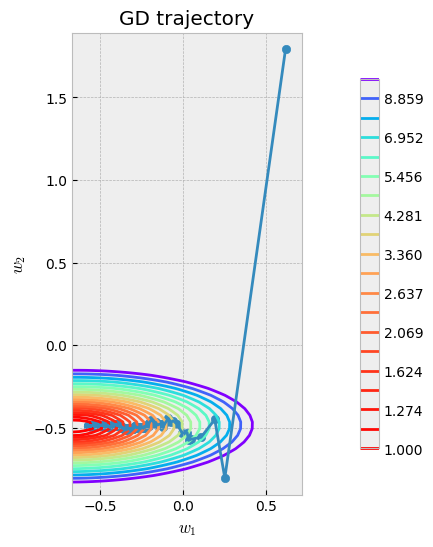

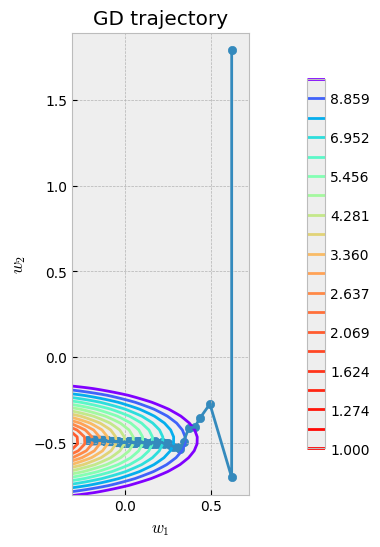

In [48]:
# creating a list with the values for the 'p' parameter
p_values = [0.1, 0.2, 0.4, 0.6, 0.8, 1]

for p in p_values:
  # calculating the weights and plotting trajectories
  resulting_weights = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, p, 1000)
  plot_gd(resulting_weights, X, y, loss)

# Выводы: чем больше значение параметра "p", тем, соответственно, быстрее происходит уменьшение значения шага.
# Я включала в массив с весами также и исходные веса, однако это не мешает увидеть общий тренд на плотах (plots):
# Так как при увеличении значения 'p' шаг закономерно уменьшается, траектория становится относительно равномерной и очень
# медленно приближается к минимуму (и, опять же, в общем случае, может застрять в локальном минимуме). И наоборот,
# чем меньше значение 'p', тем медленнее происходит уменьшение шага (это особенно хорошо видно на первых двух графиках) и тем ожидаемо
# более хаотично и 'noisy' ведёт себя траектория (поскольку шаги остаются большими). В таком случае, глобальный минимум может быть 'перепрыгнут'.

**Задание 1.8 (5/8 балла):** Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

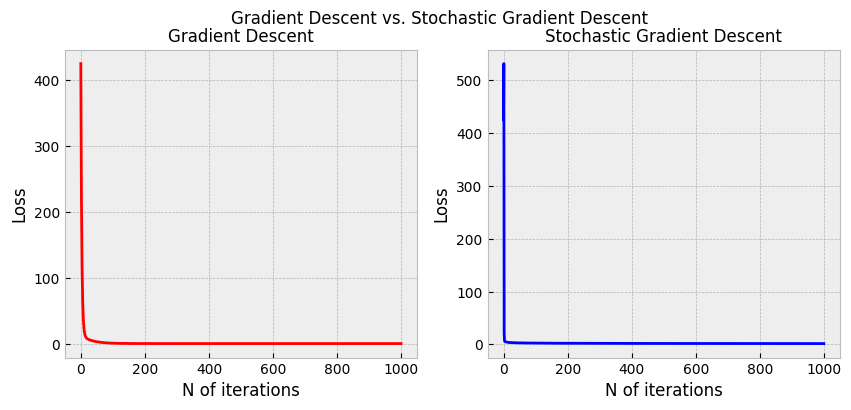

In [49]:
plt.style.use('bmh')

# arranging two subplots
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
fig.suptitle('Gradient Descent vs. Stochastic Gradient Descent')

# lists for storing the values of losses for each iteration
losses_GD = []
losses_SGD = []
number_of_iterations = 1000

# calculating the weights for each iteration (setting lr as equal to 0.001 as it seems like the optimal value of this parameter)
weights_GD = gradient_descent(w_init, X, y, loss, 0.001, number_of_iterations)
weights_SGD = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, 1, number_of_iterations)

# calculating loss for each set of weights
for iteration in range(number_of_iterations):
  losses_GD.append(loss.calc_loss(X, y, weights_GD[iteration]))
  losses_SGD.append(loss.calc_loss(X, y, weights_SGD[iteration]))

# plotting the losses for a default GD:
axs[0].plot(range(number_of_iterations), losses_GD, color = 'red', label = 'Gradient Descent')
axs[0].set_title('Gradient Descent', fontsize = 12)
axs[0].set_xlabel('N of iterations', fontsize = 12)
axs[0].set_ylabel('Loss', fontsize = 12)

# plotting the losses for SGD:
axs[1].plot(range(number_of_iterations), losses_SGD, color = 'blue', label = 'Stochastic GD')
axs[1].set_title('Stochastic Gradient Descent', fontsize = 12)
axs[1].set_xlabel('N of iterations', fontsize = 12)
axs[1].set_ylabel('Loss', fontsize = 12)

plt.show()

# Выводы: преимущество SGD на данном графике не видно (полноценно. Однако, если присмотреться, то разница заметна ), 
# поскольку сама выборка состоит  из 300 объектов, что довольно немного.
# Из-за небольшого размера такой выборки SGD оказывается ненамного быстрее классического градиентного спуска, отсюда и 
# отсутствие ожидаемого контраста. Но, как и было отмечено ранее, при более внимательном рассмотрении предложенных
# графиков, можно увидеть, что SGD действует всё же быстрее обычного GD.

## Часть 2. Линейная регрессия (5 баллов)

Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`

В методе `predict` мы будем применять нашу регрессию к датасету, 

**Задание 2.1 (5/8 балла):** Допишите код в методах `fit` и `predict` класса `LinearRegression`

В методе `fit` вам нужно как-то инициализировать веса `w`, применить `gradient_descent` и сохранить последнюю `w` из траектории.

В методе `predict` вам нужно применить линейную регрессию и вернуть вектор ответов.

Обратите внимание, что объект лосса передаётся в момент инициализации и хранится в `self.loss`. Его нужно использовать в `fit` для `gradient_descent`.

In [50]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr
        self.w = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        # initializing random weights by calculating the number of features in X:
        number_of_features = X.shape[1] 
        initial_weights = np.random.uniform(-2, 2, (number_of_features, ))

        # calculating the weights and getting the last (optimal) ones:
        self.w = gradient_descent(initial_weights, X, y, self.loss, self.lr, 10000)[-1]

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        # initializing and calculating a vector of predicted target values:
        y_predicted = np.dot(X, self.w)

        return y_predicted

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации. 

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [51]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [52]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [53]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

**Задание 2.2 (5/8 балла):** Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [54]:
# Чтобы избежать 'data leakage', я сначала заполню пропуски в данных, затем 
# закодирую категориальные переменные. Только после этого я разделю датасет на обучающую и
# тестовую выборки и нормализую числовые признаки (по плану-последовательности, указанному в 4ом домашнем задании).

from sklearn.impute import SimpleImputer

X_raw.columns = X_raw.columns.astype(str) # converting feature names to 'str' format, otherwise an error occurs

# checking if there are any missing values present
X_raw.isnull().values.any() # output: True -> missing values found

# finding categorical features:
cat_features_mask = (X_raw.dtypes == "object").values

# filling in the blanks for numerical features with mean values:
X_real = X_raw[X_raw.columns[~cat_features_mask]]
mis_replacer = SimpleImputer(strategy = "mean")
X_no_mis_real = pd.DataFrame(data = mis_replacer.fit_transform(X_real), columns = X_real.columns)

# filling in the blanks for categorical features with empty strings:
X_no_mis_cat = X_raw[X_raw.columns[cat_features_mask]].fillna('')
X_no_mis = pd.concat([X_no_mis_real, X_no_mis_cat], axis = 1)

# checking if there are any missing values present
X_no_mis.isnull().values.any() # output: False -> missing values found

X_no_mis.head()

# Поскольку целевая переменная y, взятая из изначального сета X_raw, не содержит пропусков (они были дропнуты в 32ом блоке),
# именно она в дальнейшем используется при разделении датасета. Однако, если бы пропуски удалены бы не были, я бы
# могла сначала обработать X_raw, не дропая 25ый признак (это и есть целевая переменная), и только потом, обработав
# все существующие признаки, выцепить оттуда целевую переменную. Однако в 'y' и так не было пропусков, поэтому для 
# выделения целевой переменной из датасета я использовала необработанный X_raw (как и было написано в дефолтном предложенном сниппете кода).

,index,0,1,9,10,11,12,13,16,18,...,2,3,4,5,6,7,8,14,15,17
0,0.0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,1.0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,2.0,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,...,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,3.0,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,...,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,4.0,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,...,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi


In [55]:
# encoding categorical features(one-hot) : 
X_dummies = pd.get_dummies(X_no_mis, drop_first = True)
X_dummies.head()

,index,0,1,9,10,11,12,13,16,18,...,15_three,15_twelve,15_two,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
0,0.0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,...,0,0,0,0,0,0,0,1,0,0
1,1.0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,...,0,0,0,0,0,0,0,1,0,0
2,2.0,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,...,0,0,0,0,0,0,0,1,0,0
3,3.0,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,...,0,0,0,0,0,0,0,1,0,0
4,4.0,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,...,0,0,0,0,0,0,0,1,0,0


In [56]:
from sklearn.model_selection import train_test_split

np.random.seed(32)  # fixating random seed

# y.isnull().values.any() -> Output: False -> we'll use initial 'y' when splitting the data and
# X_no_mis instead of X_raw to ensure the usage of a data set with no missing values

# splitting the data into train and test parts
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size = 0.3, random_state = 32)

In [57]:
# normalizing numerical features: 
from sklearn import preprocessing

normalizer = preprocessing.MinMaxScaler() # creating an instance of a scaler
X_train_normalized = normalizer.fit_transform(X_train)
X_test_normalized = normalizer.transform(X_test) # calling 'fit' only on the training part

# creating new normalize data frames:
X_train = pd.DataFrame(data = X_train_normalized)
X_test = pd.DataFrame(data = X_test_normalized)

# X_train.head()

**Задание 2.3 (5/8 балла):** Обучите написанную вами линейную регрессию на обучающей выборке

In [58]:
linear_regression.fit(X_train, y_train)

**Задание 2.4 (5/8 балла):** Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода `mean_squared_error` из `sklearn.metrics`.

In [59]:
from sklearn.metrics import mean_squared_error

y_pred = linear_regression.predict(X_train)
MSE_train = mean_squared_error(y_train, y_pred)

y_pred_test = linear_regression.predict(X_test)
MSE_test = mean_squared_error(y_test, y_pred_test)

print(f'The MSE on the training set is: {MSE_train}')
print(f'The MSE on the test set is: {MSE_test}')

# we get a small MSE on the training set and a much bigger value of MSE on the test set -> a clear sign of overfitting

The MSE on the training set is: 2104893.958828791
The MSE on the test set is: 8158835.634027516


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

**Задание 2.5 (5/8 балла):** Реализуйте класс `MSEL2Loss`

Он должен вычислять лосс и градиент по формулам наверху

Подсказка: обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак). Как мы знаем из лекций и семинаров, bias регуляризовать не нужно. Поэтому не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [60]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        # calculating the first summand
        first_summand = np.square(np.dot(X, w) - y).mean(axis = None) 

        # then calculating the overall loss by adding L2:
        euc_weights = np.square(np.linalg.norm(w[:-1]))
        loss = first_summand + self.coef * euc_weights

        return loss

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        
        # calculating the first summand:
        first_summand = (2 / X.shape[0]) * (np.dot(X.T, (np.dot(X, w) - y)))

        # zeroing out the last element in w:
        w_zeroed = w.copy()
        w_zeroed[-1] = 0

        # calculating the gradient:
        grad = first_summand + 2 * self.coef * w_zeroed

        return grad

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [61]:
linear_regression = LinearRegression(MSEL2Loss(0.1))

**Задание 2.6 (5/8 балла):** Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации. 

In [62]:
# training a model:
linear_regression.fit(X_train, y_train)

# getting the result:
y_train_predicted = linear_regression.predict(X_train)
y_test_predicted = linear_regression.predict(X_test)

# calculating the MSE:
MSE_train = mean_squared_error(y_train, y_train_predicted)
MSE_test = mean_squared_error(y_test, y_test_predicted)

print(f'The MSE for MSE with L2 on the training set is: {MSE_train}')
print(f'The MSE for MSE with L2 on the test set is: {MSE_test}')

The MSE for MSE with L2 on the training set is: 10513930.807121754
The MSE for MSE with L2 on the test set is: 6548167.464533015


In [63]:
# trying to find a better value of lambda:
lambdas = [0.001, 0.01, 0.05, 0.5]
linear_regressors = [] # a list to store all the models with different lambda parameters

# lists of MSE values for each model
MSE_train_values = []
MSE_test_values = []

for lambda_value in lambdas:
  linear_regressor = LinearRegression(MSEL2Loss(lambda_value))
  linear_regressor.fit(X_train, y_train)
  linear_regressors.append(linear_regressor)

for model in linear_regressors:
  # predicting values of the targer variable
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  # calculating MSE and appending to previously initialized lists:
  MSE_train = mean_squared_error(y_train, y_pred_train)
  MSE_test = mean_squared_error(y_test, y_pred_test)

  MSE_train_values.append(MSE_train)
  MSE_test_values.append(MSE_test)

In [64]:
# creating a data frame and plot to illustrate the results:
lambdas_df = pd.DataFrame({'Values of lambda: ': lambdas})
lambdas_df.index += 1

lambdas_df['MSE train'] = MSE_train_values
lambdas_df['MSE test'] = MSE_test_values

lambdas_df 
# Выводы: анализируя полученную табличку, приходим к выводу, что оптимальным значением
# параметра lambda будет: 0,01. Теперь, имея полученные данные, можем сравнить данную модель
# с моделью без регуляризатора.

,Values of lambda:,MSE train,MSE test
1,0.001,2.362218e+06,5.202265e+06
2,0.010,4.245546e+06,3.073236e+06
3,0.050,7.941269e+06,5.050874e+06
4,0.500,2.160745e+07,1.309182e+07


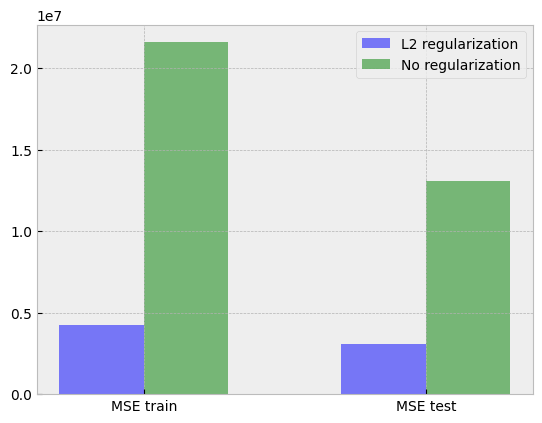

In [65]:
# comparing models with L2 regulation and without it:
labels = ["MSE train", "MSE test"]

# setting the values for each bar:
L2_model = [MSE_train_values[1], MSE_test_values[1]]
lin_model = [MSE_train, MSE_test]

# setting the correct position of the bars:
x_L2_train = [0]
x_L2_test = [1]
x_lin_train = [0.3]
x_lin_test = [1.3]

# creating the bar chart:
plt.bar(x_L2_train, L2_model[0], width=0.3, color='blue', alpha=0.5, label='L2 regularization')
plt.bar(x_lin_train, lin_model[0], width=0.3, color='green', alpha=0.5, label='No regularization')
plt.bar(x_L2_test, L2_model[1], width=0.3, color='blue', alpha=0.5)
plt.bar(x_lin_test, lin_model[1], width=0.3, color='green', alpha=0.5)

plt.xticks([0.15, 1.15], labels)
plt.legend()
plt.show()

# На графике хорошо видно, что результаты модели с L2 регуляризатором значительно
# превосходят результаты модели без него как на обучающей, так и на тестовой выборке.

В нашем датасете могут быть выбросы. На семинаре вам рассказывали, что с выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

**Задание 2.7 (5/8 балла):** Реализуйте класс `HuberLoss`

Он должен вычислять лосс и градиент по формулам наверху

In [66]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        
        # storing losses for each object to get 'mean' in the end:
        losses = []
        # storing the number of objects and predictions:
        number_of_objects = X.shape[0]
        predicted_values = np.dot(X, w)

        for i in range(number_of_objects):
            # calculating the difference ('z' in the formula):
            z = predicted_values[i] - y[i]

            if (abs(z) <= self.eps):
              loss = 1/2 * z ** 2
            else:
              loss = self.eps * (abs(z) - 1/2 * self.eps)

            losses.append(loss)  # appending the value of a loss

        return np.mean(losses)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        # initializing 'gradient' vector of partial derivatives as zero-like:
        gradient = np.zeros_like(w)

        # storing the number of objects and predictions:
        number_of_objects = X.shape[0]
        predicted_values = np.dot(X, w)

        for i in range(number_of_objects):
          # calculating the difference:
          z = predicted_values[i] - y[i]

          if (abs(z) <= self.eps):
              pheta = z
          else:
            pheta = self.eps * np.sign(z)

          # calculating a partial derivative:
          gradient += X[i] * pheta

        return gradient / number_of_objects

**Задание 2.8 (5/8 балла):** Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [67]:
# finding the best value of the hyper-parameter epsilon
epsilons = [0.5, 2.0, 5.0, 10.0, 15.0]
models = []

# lists of MSE values for each model
MSE_train_values_Huber = []
MSE_test_values_Huber = []

for epsilon in epsilons:
  model = LinearRegression(HuberLoss(epsilon))
  model.fit(X_train, y_train)
  models.append(model)

for model in models:
  y_train_predicted = model.predict(X_train)
  y_test_predicted = model.predict(X_test)

  # calculating the MSE:
  MSE_train = mean_squared_error(y_train, y_train_predicted)
  MSE_test = mean_squared_error(y_test, y_test_predicted)

  MSE_train_values_Huber.append(MSE_train)
  MSE_test_values_Huber.append(MSE_test)

In [68]:
# creating a DataFrame to choose the best value of epsilon:
epsilons_df = pd.DataFrame({'Values of epsilon: ': epsilons})
epsilons_df.index += 1

epsilons_df['MSE train'] = MSE_train_values_Huber
epsilons_df['MSE test'] = MSE_test_values_Huber

epsilons_df 
# Выводы: по табличке видно, что значение MSE падает с увеличением epsilon (большее значение epsilon делает
# Huber loss менее чувствительным к outliers). Это значит, что в нашем датасете их мало, а MSE, соответственно,
# будет показывать в данном случае лучший результат (опять же, из-за отсутствия 'выбросов' в данном датасете).

,Values of epsilon:,MSE train,MSE test
1,0.5,1.649919e+08,1.147907e+08
2,2.0,7.632067e+07,4.749896e+07
3,5.0,4.647261e+07,2.592746e+07
4,10.0,2.962067e+07,1.580643e+07
5,15.0,2.486483e+07,1.354779e+07


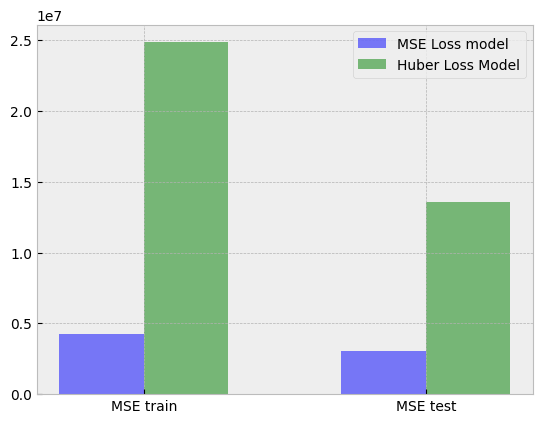

In [69]:
# comparing the models taught based on Huber Loss and MSE:
labels = ["MSE train", "MSE test"]

# setting the values for each bar:
L2_model = [MSE_train_values[1], MSE_test_values[1]]
Huber_loss_model = [MSE_train_values_Huber[4], MSE_test_values_Huber[4]]

# setting the correct position of the bars:
x_L2_train = [0]
x_L2_test = [1]
x_Huber_train = [0.3]
x_Huber_test = [1.3]

# creating the bar chart:
plt.bar(x_L2_train, L2_model[0], width=0.3, color='blue', alpha=0.5, label = 'MSE Loss model')
plt.bar(x_Huber_train, Huber_loss_model[0], width=0.3, color='green', alpha=0.5, label='Huber Loss Model')
plt.bar(x_L2_test, L2_model[1], width=0.3, color='blue', alpha=0.5)
plt.bar(x_Huber_test, Huber_loss_model[1], width=0.3, color='green', alpha=0.5)

plt.xticks([0.15, 1.15], labels)
plt.legend()
plt.show()

# На графике хорошо видно, что результаты модели, обученной на основе MSE, показывают
# значительно лучшие результаты. Подчеркну еще раз, что это возможно из-за отсутствия в датасете 
# 'выбросов', на которые, как правило, и рассчитано использование Huber Loss при обучении модели.

**Задание 3 (0.08/8 балла)**
Вставьте ваш любимый мем 2021 в ячейку ниже:

In [70]:
# -- YOUR MEME HERE --

### БОНУС (2.5 баллов)

Градиентный спуск — далеко не единственный метод оптимизации. 
Другой очень известный метод называется ["Алгоритм имитации отжига"](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B8%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%BE%D1%82%D0%B6%D0%B8%D0%B3%D0%B0). Он не так часто используется для оптимизации моделей машинного обучения, но у вас есть уникальная возможность попробовать применить его к нашей любимой линейной регрессии.

**Задание (2.5 баллов)**:
Напишите алгоритм имитации отжига для оптимизации MSE линейной регрессии. 

Сравните результат с градиентным спуском по "траектории" и по финальному лоссу.

Подсказка: каждую новую точку (веса регресси в нашем случае) можно семплировать из некоторого случайного распределением с центром в текущей точке. Хорошо подойдут распределения с "тяжёлыми" хвостами, например, распределение Стьюдента с параметром количества степеней свободы в районе 3.
Это может выглядеть, например, так:
```
new_w = old_w + np.random.standard_t(3, size=old_w.shape)
```
С параметром распределения можно поэксперементировать: чем он больше, тем реже новые точки будут очень сильно уходить от старых.

In [102]:
def simulated_annealing(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    initial_temperature: float,
    alpha_coef: float = 0.95,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция имитации отжига
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param temperature: float - начальное значение температуры, изменяющееся в ходе алгоритма
    :alpha_coef: float - коэффициент охлаждения, определяющий, насколько быстро уменьшается
    температура на каждой итерации
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """

    weights_history = [w_init] # storing the history of weights
    curr_temperature = initial_temperature

    # starting the process of annealing:
    for i in range(n_iterations):
      old_w = weights_history[-1]

      # generating new weights using Student's distribution:
      new_w = old_w + np.random.standard_t(4, size = old_w.shape)

      # calculating the loss on the new set of weights:
      old_loss = loss.calc_loss(X, y, old_w)
      new_loss = loss.calc_loss(X, y, new_w)

      # calculating new acceptance probability for the weights using the Metropolis criterion:
      accept_prob = np.exp((new_loss - old_loss) / curr_temperature)

      # checking if the new weights are passing a random threshold:
      # (= случайность выбора промежуточной точки в соответствии с wiki)
      # we can also establish a threshold 
      if accept_prob > np.random.rand():
        weights_history.append(new_w)

      else:
        weights_history.append(old_w)

      # cooling down the temperature:
      curr_temperature = curr_temperature * alpha_coef
    
    return weights_history

In [105]:
# generating data to check the quality of the new function:
np.random.seed(1337)

n_features = 2
n_objects = 300

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

In [111]:
loss = MSELoss()
w_list = simulated_annealing(w_init, X, y, loss, 0.6)
print(loss.calc_loss(X, y, w_list[-1]))

20857249.08733029


<ipython-input-102-ee91ca842a4b>:37: RuntimeWarning: overflow encountered in exp
  accept_prob = np.exp((new_loss - old_loss) / curr_temperature)
